# Heat Stress
This breaks down each contribution to the theoretical scaling factor.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g, R, radius_earth
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_scaling_factor_theory

2024-09-12 15:55:20,953 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)
p_surface_approx = np.inf          # Desired approximate pressure of surface (hPa)

# Load dataset
# exp_dir = 'rossbypalooza/lat_20/'
# rot_rate = [0.25, 0.5, 1, 2, 4]
# exp_dir = 'rossbypalooza/lat_20/'
# rot_rate = [1]
exp_dir = '/Users/joshduffield/Library/CloudStorage/OneDrive-UniversityofStAndrews/isca_output/rossbypalooza/sst_increase/'                # land with fixed SST
rot_rate = ['zonal_land_SSTm2_1', 'zonal_land_SSTp1_1']
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/ras_conv/'

# only keep variables required to compute relative humidity and MSE
var_keep = ['temp', 'sphum', 't_surf', 'precipitation', 'ucomp', 'vcomp']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']
# rot_rate = [1, 2]
n_exp = len(rot_rate)
exp_names = [f'{rot_rate[i]}'.replace('.', '_') for i in range(len(rot_rate))]
color_seq_rot = plt.cm.jet(np.linspace(0,1,n_exp))
ds = []
albedo = []
tau_sw = []
tau_lw = []
omega = []
time_start = 100
time_final = 9999999999999999
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for j in range(n_exp):
        ds_use = isca_tools.load_dataset(exp_dir + exp_names[j]).sel(time=slice(time_start, time_final))
        
        ds += [ds_use.sel(pfull=[p_surface_approx, pressure_ft], 
                          method='nearest')[var_keep].load()]  # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + exp_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        omega += [namelist['constants_nml']['omega']]
        pbar.update(1)
omega = np.asarray(omega)        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size

100%|██████████| 2/2 [00:05<00:00,  2.77s/it]


## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [5]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]       # get the longitude coordinates of land
    lat_land_min = float(lat_land.min())
    lat_land_max = float(lat_land.max())
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
else:
    lat_land_min = None
    lat_land_max = None

def show_land(ax, lat_land_min=lat_land_min, lat_land_max=lat_land_max, lat_ax='x', color_land='g', lw_land=4):
    if is_land_data:
        if not isinstance(ax, (list, np.ndarray)):
            raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
        for i in range(len(ax)):
            if lat_ax == 'x':
                var = ax[i].get_ylim()[0]
                xlim = ax[i].get_xlim()
                ax[i].hlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_ylim(var, ax[i].get_ylim()[1])
                ax[i].set_xlim(xlim)
            elif lat_ax == 'y':
                var = ax[i].get_xlim()[0]
                ylim = ax[i].get_ylim()
                ax[i].vlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_xlim(var, ax[i].get_xlim()[1])
                ax[i].set_ylim(ylim)
            else:
                raise ValueError(f'lat_ax must be either x or y, but {lat_ax} was given.')

### MSE as function of rotation rate
In summer (JJA), expect near-surface MSE to be peaked off-equator, and size of peak relative to equator to increase with rotation rate. We show that we do see this below.

In [6]:
def get_z_theory(temp_surf, temp_ft, taylor=True, pressure_surf=p_surface, pressure_ft=pressure_ft_actual):
    lnp_prefactor = R * np.log(pressure_surf/pressure_ft) / g
    if taylor:
        return lnp_prefactor/2 * (temp_surf + temp_ft)
    else:
        return lnp_prefactor * (temp_surf - temp_ft) / np.log(temp_surf/temp_ft)



In [19]:
summer_months = [6, 7, 8]
z_ft_theory = [get_z_theory(ds[i].temp.isel(pfull=ind_surf), ds[i].temp.isel(pfull=ind_ft)) for i in range(n_exp)]
z_ft_theory_av_summer = np.asarray([annual_time_slice(z_ft_theory[i], include_months=summer_months).mean(dim=['time', 'lon']) for i in range(n_exp)])

ds_av_summer = [annual_time_slice(ds[i], include_months=summer_months).mean(dim=['time', 'lon']) for i in range(n_exp)]
mse_av_summer = [moist_static_energy(ds_av_summer[i].temp.isel(pfull=ind_surf), ds_av_summer[i].sphum.isel(pfull=ind_surf), 0) for i in range(n_exp)]
mse_ft_av_summer = [moist_static_energy(ds_av_summer[i].temp.isel(pfull=ind_ft), 
                                        sphum_sat(ds_av_summer[i].temp.isel(pfull=ind_ft), pressure_ft_actual), 
                                        z_ft_theory_av_summer[i]) for i in range(n_exp)]
n_lat = int(ds_av_summer[0].lat.size)
temp_ft_adiabat = np.zeros((n_exp, n_lat))
for i in range(n_exp):
    for j in range(n_lat):
        temp_ft_adiabat[i, j] = get_temp_adiabat(float(ds_av_summer[i].temp.isel(pfull=ind_surf, lat=j)), 
                                                 float(ds_av_summer[i].sphum.isel(pfull=ind_surf, lat=j)), 
                                                 p_surface, pressure_ft_actual)

In [8]:
# Need to average over subtropics and over equator, specify these regions here
# lat_subtrop_min = 25
# lat_subtrop_max = 40
# 
# lat_equator_min = -10
# lat_equator_max = 10

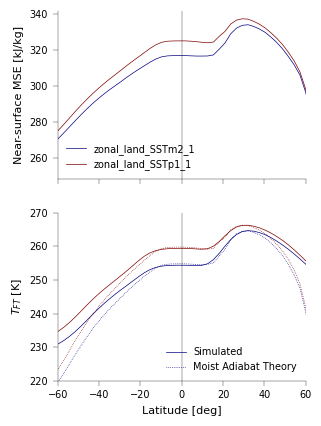

In [9]:
save_mse_lat_fig = True
color_seq_rot = plt.cm.jet(np.linspace(0,1,n_exp))
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(ds[0].lat, mse_av_summer[i], color=color_seq_rot[i], label=rot_rate[i])
    ax[1].plot(ds[0].lat, ds_av_summer[i].temp.isel(pfull=ind_ft), color=color_seq_rot[i], label='Simulated' if i==0 else None)
    ax[1].plot(ds[0].lat, temp_ft_adiabat[i], color=color_seq_rot[i], linestyle=':', label='Moist Adiabat Theory' if i==0 else None)
# ax[0].set_xlim(-10, 50)
# ax[0].set_ylim(270, 300)
# ax[1].set_ylim(250, 275)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
show_land(ax)
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Near-surface MSE [kJ/kg]')
ax[1].set_ylabel('$T_{FT}$ [K]')
ax[0].set_xlim(-60, 60)
ax[1].set_ylim(220, 270)
if save_fig or save_mse_lat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_lat_summer.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

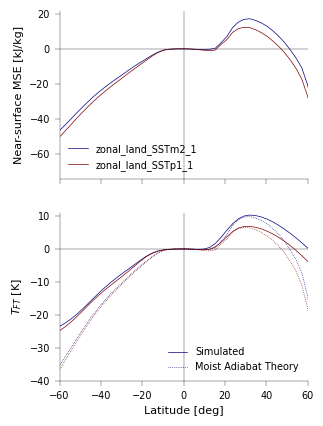

In [10]:
save_mse_lat_diff_fig = True
ind_equator = int(np.abs(ds_av_summer[0].lat).argmin())
color_seq_rot = plt.cm.jet(np.linspace(0,1,n_exp))
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(ds[0].lat, mse_av_summer[i]-mse_av_summer[i][ind_equator], color=color_seq_rot[i], label=rot_rate[i])
    ax[1].plot(ds[0].lat, ds_av_summer[i].temp.isel(pfull=ind_ft)-ds_av_summer[i].temp.isel(pfull=ind_ft)[ind_equator],
               color=color_seq_rot[i], label='Simulated' if i==0 else None)
    ax[1].plot(ds[0].lat, temp_ft_adiabat[i]-temp_ft_adiabat[i, ind_equator], color=color_seq_rot[i], linestyle=':', label='Moist Adiabat Theory' if i==0 else None)
# ax[0].set_xlim(-10, 50)
# ax[0].set_ylim(270, 300)
# ax[1].set_ylim(250, 275)
ax[0].axvline(0, color='k', lw=ax_linewidth)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
show_land(ax)
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Near-surface MSE [kJ/kg]')
ax[1].set_ylabel('$T_{FT}$ [K]')
ax[0].set_xlim(-60, 60)
ax[1].set_ylim(-40, 11)
if save_fig or save_mse_lat_diff_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_lat_summer_diff.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Scaling Factor Theory for $\delta T_s$
Above it is clear that the lapse rate between the surface and 500hPa is approximately moist adiabatic for both simulations. 
Given this constraint, how much of the change in near-surface temperature is due to mechanisms other than change in free tropospheric temperature?

Below we see that the land warms less than the equator almost entirely because of the suppressed warming at the FT level - theory almost entirely due to green line.

In [31]:
temp_av_summer = np.asarray([ds_av_summer[i].temp for i in range(n_exp)])
sphum_av_summer = np.asarray([ds_av_summer[i].sphum[ind_surf] for i in range(n_exp)])
sf_theory, _, _, sf_cont, _ = get_scaling_factor_theory(temp_av_summer[:, ind_surf, ind_equator], temp_av_summer[:, ind_surf], 
                                              sphum_av_summer[:, ind_equator], sphum_av_summer, p_surface, pressure_ft_actual,
                                              temp_av_summer[:, ind_ft, ind_equator], temp_av_summer[:, ind_ft], 
                                              z_ft_theory_av_summer[:, ind_equator], z_ft_theory_av_summer,
                                              non_linear=False, use_temp_adiabat=True, 
                                              strict_conv_eqb=True, 
                                              simple=True)

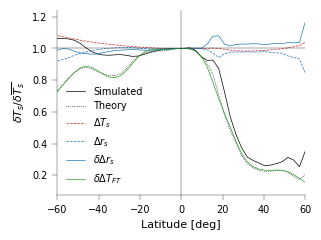

In [57]:
save_sf_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(ds[0].lat, (temp_av_summer[1, ind_surf]-temp_av_summer[0, ind_surf])/(
        temp_av_summer[1, ind_surf]-temp_av_summer[0, ind_surf])[ind_equator], color='k', label='Simulated')
ax.plot(ds[0].lat, sf_theory, color='k', linestyle=':', label='Theory')
ax.plot(ds[0].lat, sf_cont['t_mean_change']['t0']+1, color=default_colors[3], linestyle='--', label='$\Delta T_s$')
ax.plot(ds[0].lat, sf_cont['t_mean_change']['r0']+1, color=default_colors[0], linestyle='--', label='$\Delta r_s$')
ax.plot(ds[0].lat, sf_cont['anomaly_change']['r']+1, color=default_colors[0], label='$\delta \Delta r_s$')
ax.plot(ds[0].lat, sf_cont['anomaly_change']['ft']+1, color=default_colors[2], label='$\delta \Delta T_{FT}$')
ax.axhline(1, color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
ax.set_xlim(-60, 60)
ax.legend()
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$\delta T_s/\delta \overline{T_s}$')
if save_fig or save_sf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_lat_summer.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

Text(0, 0.5, '$h_s - h_{FT}^*$ [kJ/kg]')

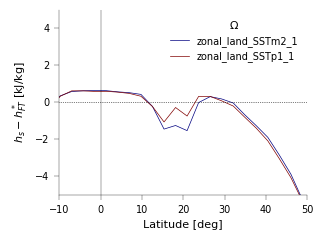

In [20]:
color_seq_rot = plt.cm.jet(np.linspace(0,1,n_exp))
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(ds[0].lat, mse_av_summer[i] - mse_ft_av_summer[i], color=color_seq_rot[i], label=rot_rate[i])
ax.set_xlim(-10, 50)
ax.set_ylim(-5, 5)
show_land([ax])
ax.axvline(0, color='k', lw=ax_linewidth)
ax.axhline(0, color='k', linestyle=':')
ax.legend(title='$\Omega$')
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$h_s - h_{FT}^*$ [kJ/kg]')